In [1]:
# Libraries

import matplotlib
import numpy
import os
import platform
import shutil
import sys
import warnings

In [2]:
# Ensure source path

ROOT = os.getcwd()

while not ROOT.endswith('upolanc-thesis') :
	ROOT = os.path.abspath(os.path.join(ROOT, os.pardir))

	if len(ROOT) < len('upolanc-thesis') :
		if   platform.system() == 'Linux' :
			ROOT = '/d/hpc/home/up4472/workspace/upolanc-thesis'
		elif platform.system() == 'Windows' :
			ROOT = 'C:\\Developer\\Workspace\\PyCharm\\Projects\\upolanc-thesis'
		else :
			raise ValueError()

		print(f'Warning : could not find correct directory, using default : {ROOT}')
		break

if ROOT not in sys.path :
	sys.path.append(ROOT)

os.chdir(ROOT)

In [3]:
# Code

from source.python.data.feature import feature_anndata
from source.python.io           import loader
from source.python.io           import writer
from source.python              import runtime

runtime.set_numpy_format()
runtime.set_pandas_format()
runtime.set_plot_theme()

# 1. Setup

In [4]:
# Setup some directory paths

CWD = ROOT
OUT = os.path.join(CWD, 'output')
RES = os.path.join(CWD, 'resources')

OUT_DATA  = os.path.join(OUT,      'nbp02-anndata')
OUT_PLOT  = os.path.join(OUT_DATA, 'plot')
RES_NBP01 = os.path.join(OUT,      'nbp01-analysis')

shutil.rmtree(OUT_DATA, ignore_errors = True)

os.makedirs(OUT_DATA, exist_ok = True)
os.makedirs(OUT_PLOT, exist_ok = True)

print(f'     Root Directory : {CWD}')
print(f'   Output Directory : {OUT_DATA}')
print(f'   Output Directory : {OUT_PLOT}')
print(f' Resource Directory : {RES_NBP01}')

     Root Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp02-anndata
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp02-anndata\plot
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp01-analysis


In [5]:
# Load the updated and synchronized data

tissue_metadata = loader.load_csv(
	filename = os.path.join(RES_NBP01, 'tissue-metadata.csv')
)

tissue_tpm = loader.load_csv(
	filename = os.path.join(RES_NBP01, 'tissue-tpm.csv')
)

In [6]:
# Define layer mapping

mapping = {
	'log1p'    : None,
	'boxcox1p' : None,
	'normal'   : 'boxcox1p',
	'standard' : 'boxcox1p'
}

In [7]:
# Define percentile functions

def percentile90 (x, axis) : return numpy.percentile(x, 90, axis = axis)
def percentile75 (x, axis) : return numpy.percentile(x, 75, axis = axis)
def percentile60 (x, axis) : return numpy.percentile(x, 60, axis = axis)

functions = [
	('mean', numpy.mean),
	('p75',  percentile75),
	('max',  numpy.max),
	('std',  numpy.std),
	('min',  numpy.min)
]

In [8]:
# Define transcripts to boxplot

# AT2G17360.1 - expressive in all-to-most tissues
# AT2G07713.1 - expressive only in senescence
# AT4G08160.1 - expressive in all but dominant in single

transcripts = ['AT2G17360.1', 'AT2G07713.1', 'AT4G08160.1']

# 2. Anndata

In [9]:
# Create anndata object from the metadata and tpm tables

with warnings.catch_warnings() :
	warnings.simplefilter('ignore')

	anndata = feature_anndata.create_anndata(
		mat = tissue_tpm,
		obs = tissue_metadata
	)

feature_anndata.show_structure(anndata)

AnnData object with n_obs × n_vars = 4077 × 20579
    obs: 'Study', 'Control', 'Senescence', 'Age', 'Tissue', 'Group', 'Perturbation'


In [10]:
# Display anndata tpm matrix information

feature_anndata.show_matrix(anndata, layer = None)

   Max value : 404,912.0
  Mean value :      36.4 ± 327.78542
Median value :       6.5
   Min value :       0.0

Total elements          :  83,900,583
Total elements =    0.0 :           0 [  0.00 %]
Total elements >    0.0 :  83,900,583 [100.00 %]
Total elements >    1.0 :  63,723,393 [ 75.95 %]
Total elements >   10.0 :  34,820,186 [ 41.50 %]
Total elements >   50.0 :  10,157,745 [ 12.11 %]
Total elements >  100.0 :   4,996,812 [  5.96 %]
Total elements >  250.0 :   1,778,142 [  2.12 %]

[[ 17.954   2.140   0.865   7.954  115.884   7.664   1.240  212.022  50.415  11.678]
 [ 19.723   0.001   1.536   8.971  121.833   4.748   1.525  204.999  37.174  10.163]
 [ 30.892   0.502   0.678  11.866  136.181   6.771   0.001  210.471  38.296  10.499]
 [ 25.349   1.455   0.655   9.906  139.984   2.458   0.933  196.179  56.662  10.310]
 [ 29.913   2.084   1.533   4.785  158.566   6.433   0.001  146.733   2.710   7.467]]


# 3. Log

In [11]:
# Compute and save the log1p tpm values

anndata = feature_anndata.compute_log1p(
	data       = anndata,
	layer      = mapping['log1p'],
	base       = 2,
	store_into = 'log1p'
)

In [12]:
# Display anndata log1p tpm matrix information

feature_anndata.show_matrix(anndata, layer = 'log1p')

   Max value :  18.62725
  Mean value :   3.00634 ± 2.23488
Median value :   2.91430
   Min value :   0.00000

Total elements        :  83,900,583
Total elements =  0.0 :           0 [  0.00 %]
Total elements >  0.0 :  83,900,583 [100.00 %]
Total elements >  1.0 :  63,723,393 [ 75.95 %]
Total elements >  3.0 :  40,852,571 [ 48.69 %]
Total elements >  5.0 :  15,827,426 [ 18.86 %]
Total elements >  7.0 :   3,861,829 [  4.60 %]
Total elements >  9.0 :     711,142 [  0.85 %]

[[  4.244   1.651   0.899   3.162   6.869   3.115   1.164   7.735   5.684   3.664]
 [  4.373   0.001   1.343   3.318   6.941   2.523   1.336   7.686   5.255   3.481]
 [  4.995   0.586   0.746   3.685   7.100   2.958   0.001   7.724   5.296   3.523]
 [  4.720   1.296   0.727   3.447   7.139   1.790   0.951   7.623   5.850   3.500]
 [  4.950   1.625   1.341   2.532   7.318   2.894   0.001   7.207   1.891   3.082]]


## 3.1 Distribution

Function : numpy.mean
Genes below 10th percentile [   0.587566] :  2,058
Genes below 30th percentile [   1.747218] :  6,174
Genes above 70th percentile [   3.982068] :  6,174
Genes above 90th percentile [   5.522020] :  2,058



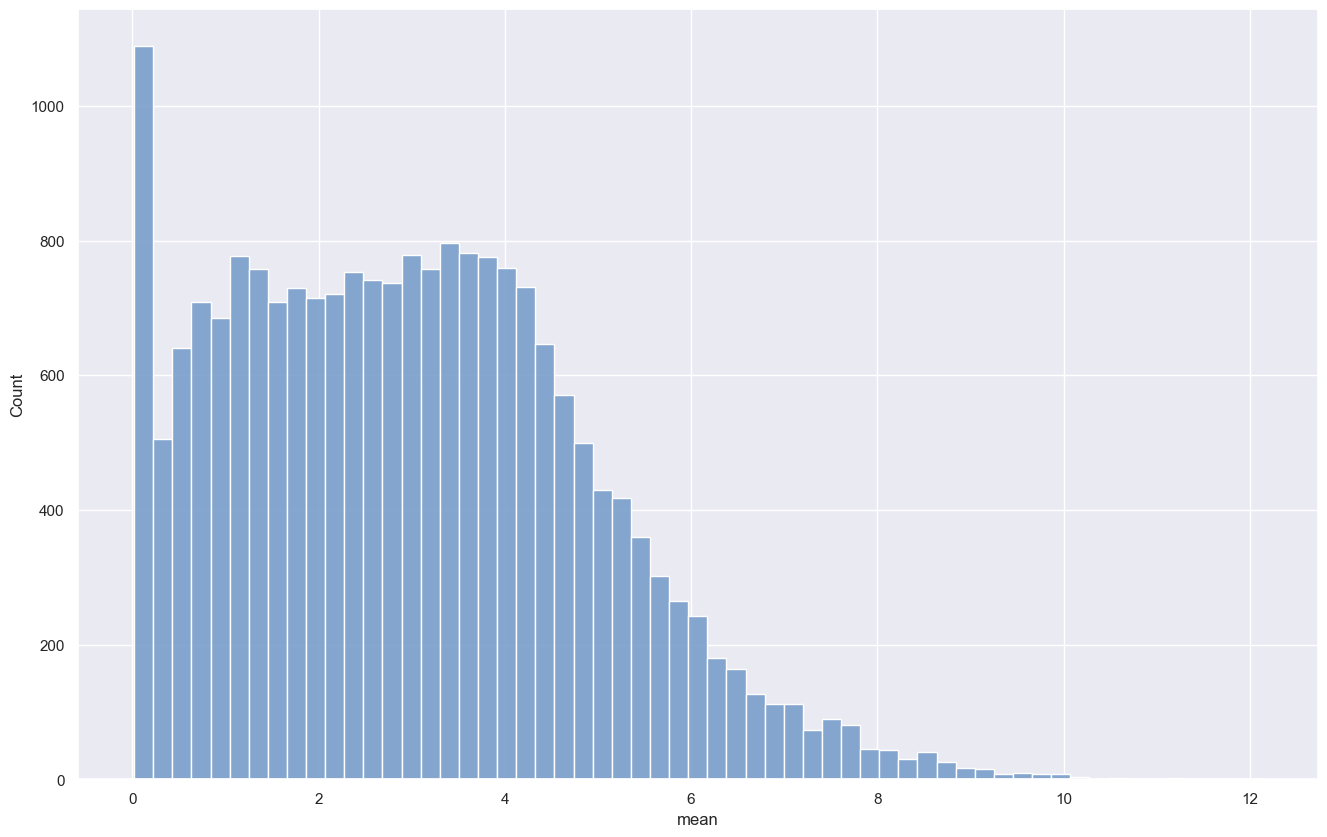

Function : __main__.percentile75
Genes below 10th percentile [   0.812965] :  2,058
Genes below 30th percentile [   2.453761] :  6,174
Genes above 70th percentile [   4.726941] :  6,174
Genes above 90th percentile [   6.328759] :  2,058



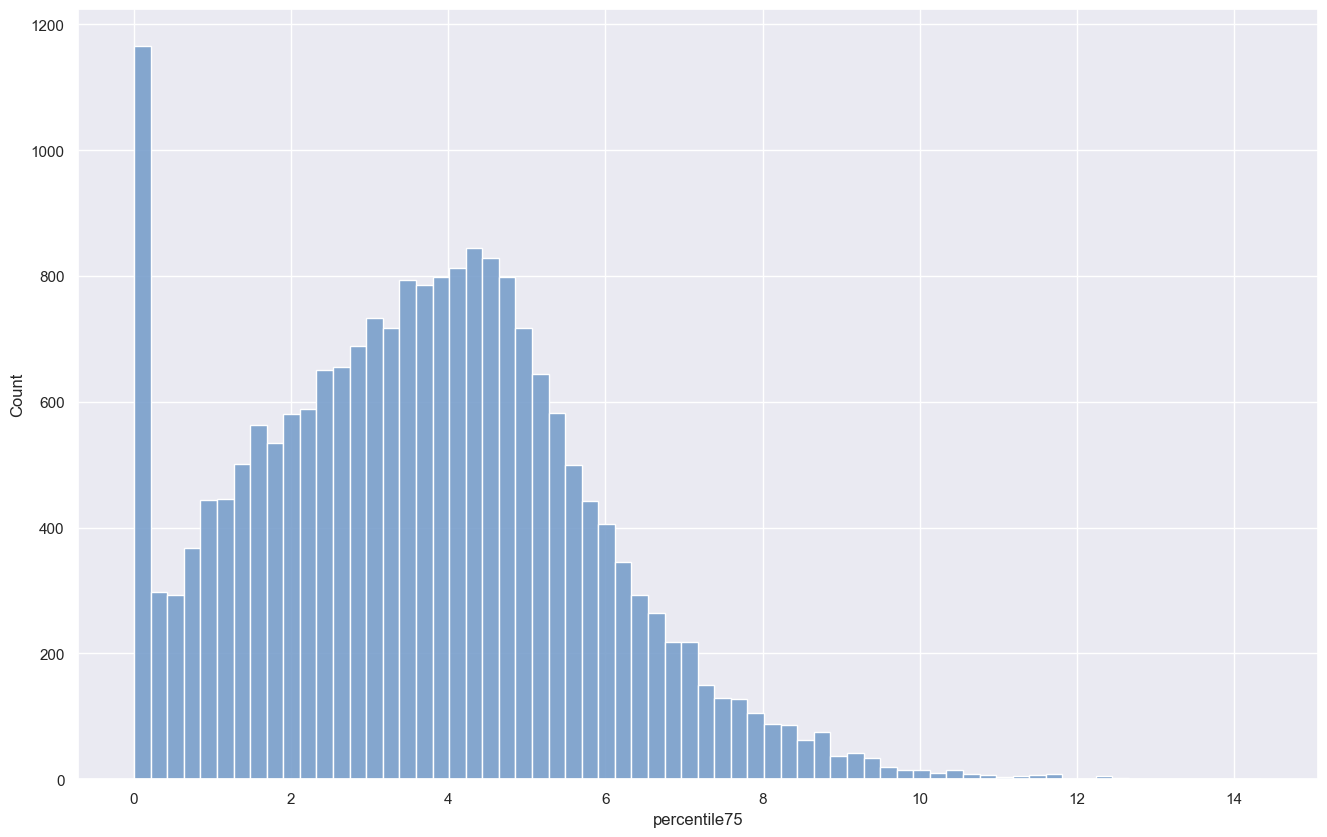

Function : numpy.amax
Genes below 10th percentile [   4.295295] :  2,058
Genes below 30th percentile [   5.641786] :  6,174
Genes above 70th percentile [   7.848366] :  6,174
Genes above 90th percentile [   9.890639] :  2,058



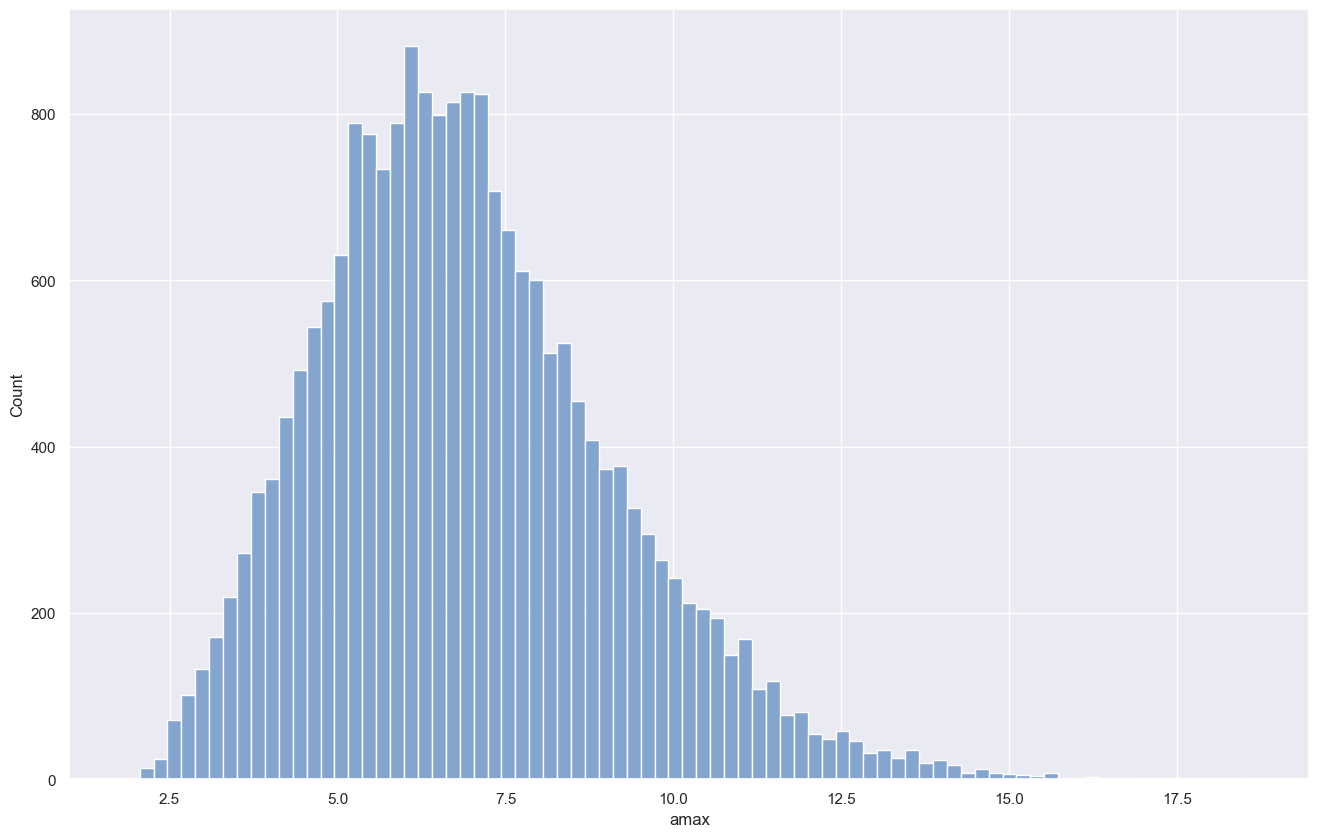

Function : numpy.std
Genes below 10th percentile [   0.611673] :  2,058
Genes below 30th percentile [   0.782785] :  6,174
Genes above 70th percentile [   1.169064] :  6,174
Genes above 90th percentile [   1.682112] :  2,058



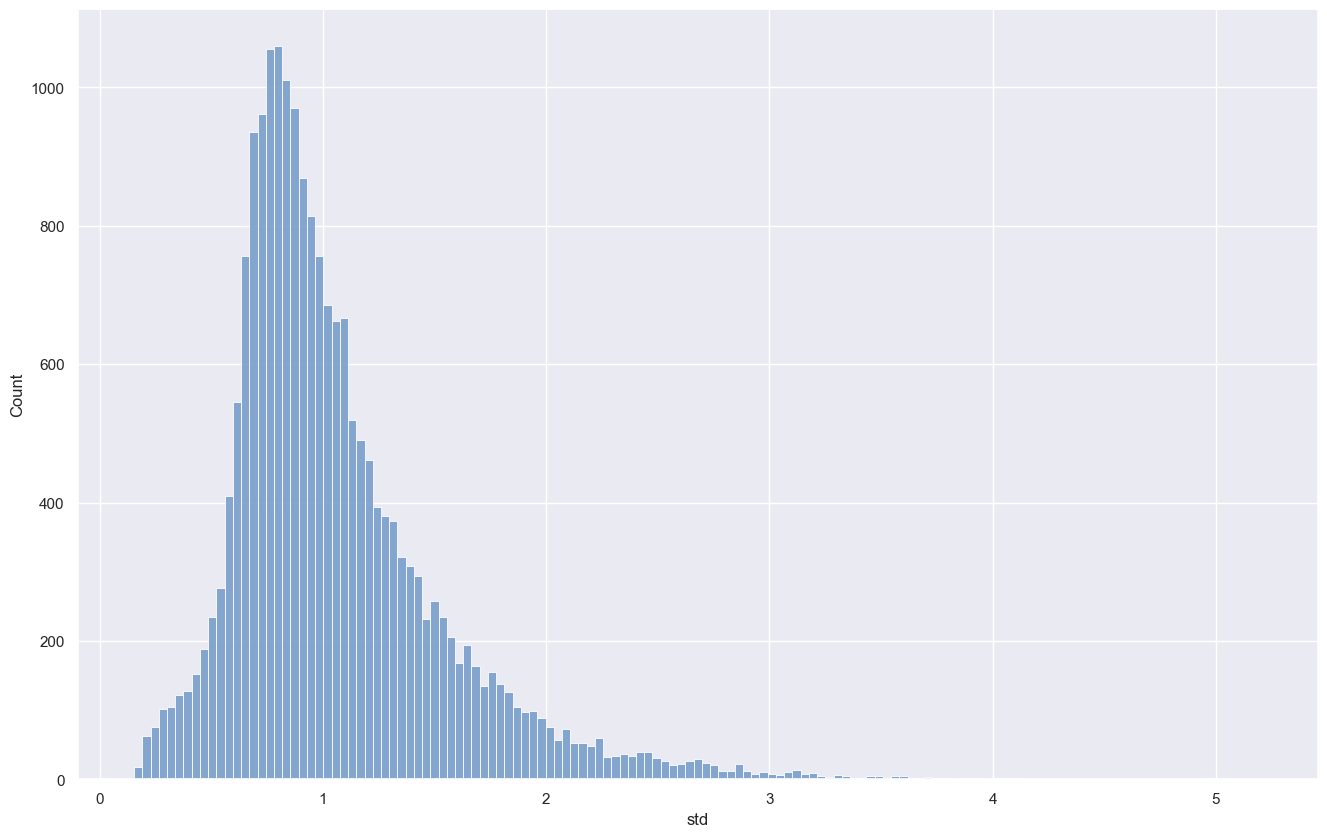

In [13]:
# Display log1p tpm value distribution per gene

for name, function in functions :
	if name == 'min' : continue

	feature_anndata.tpm_histplot(
		data     = anndata,
		layer    = 'log1p',
		function = function,
		filters  = None,
		filename = os.path.join(OUT_PLOT, 'distribution-log1p-' + name)
	)

	matplotlib.pyplot.show()

## 3.2 Transcripts

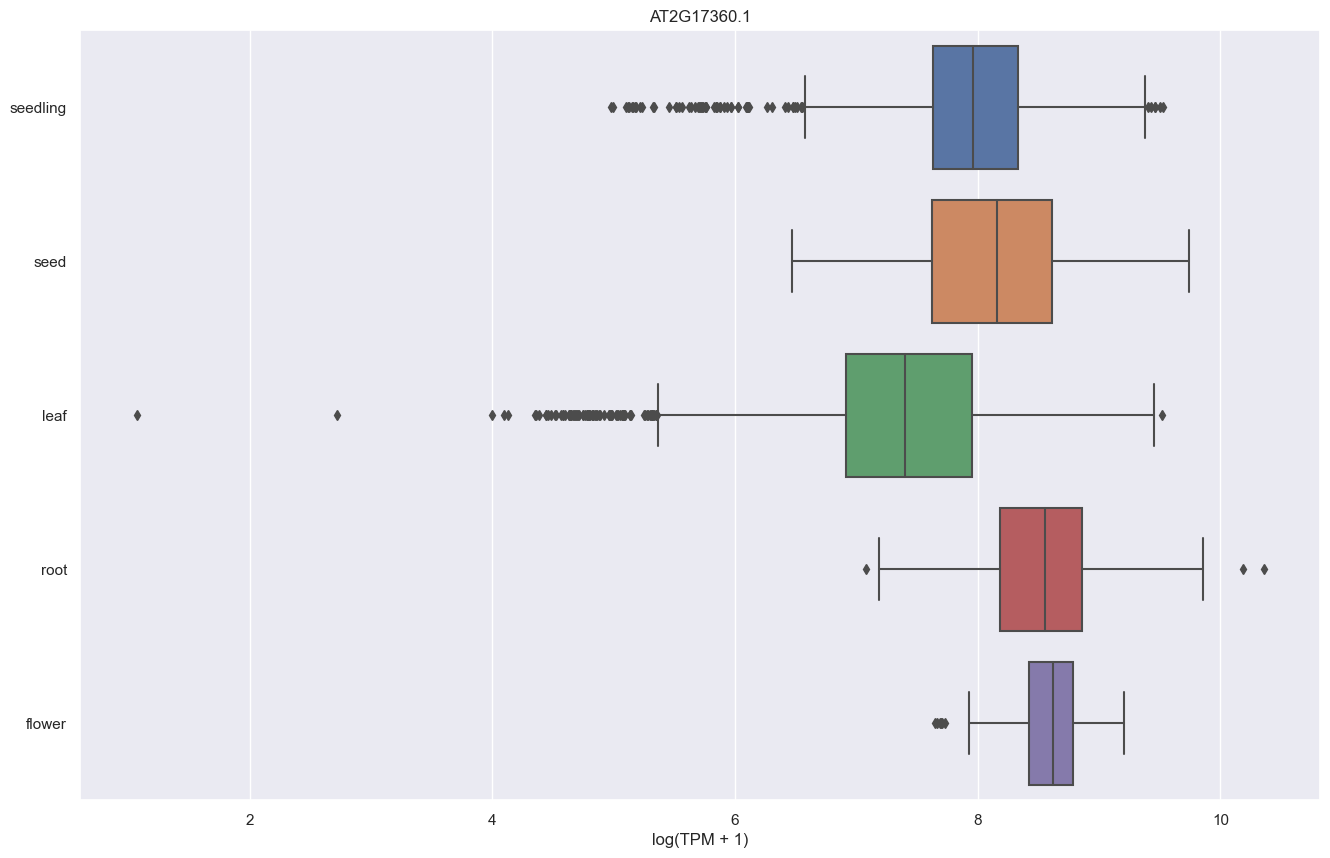

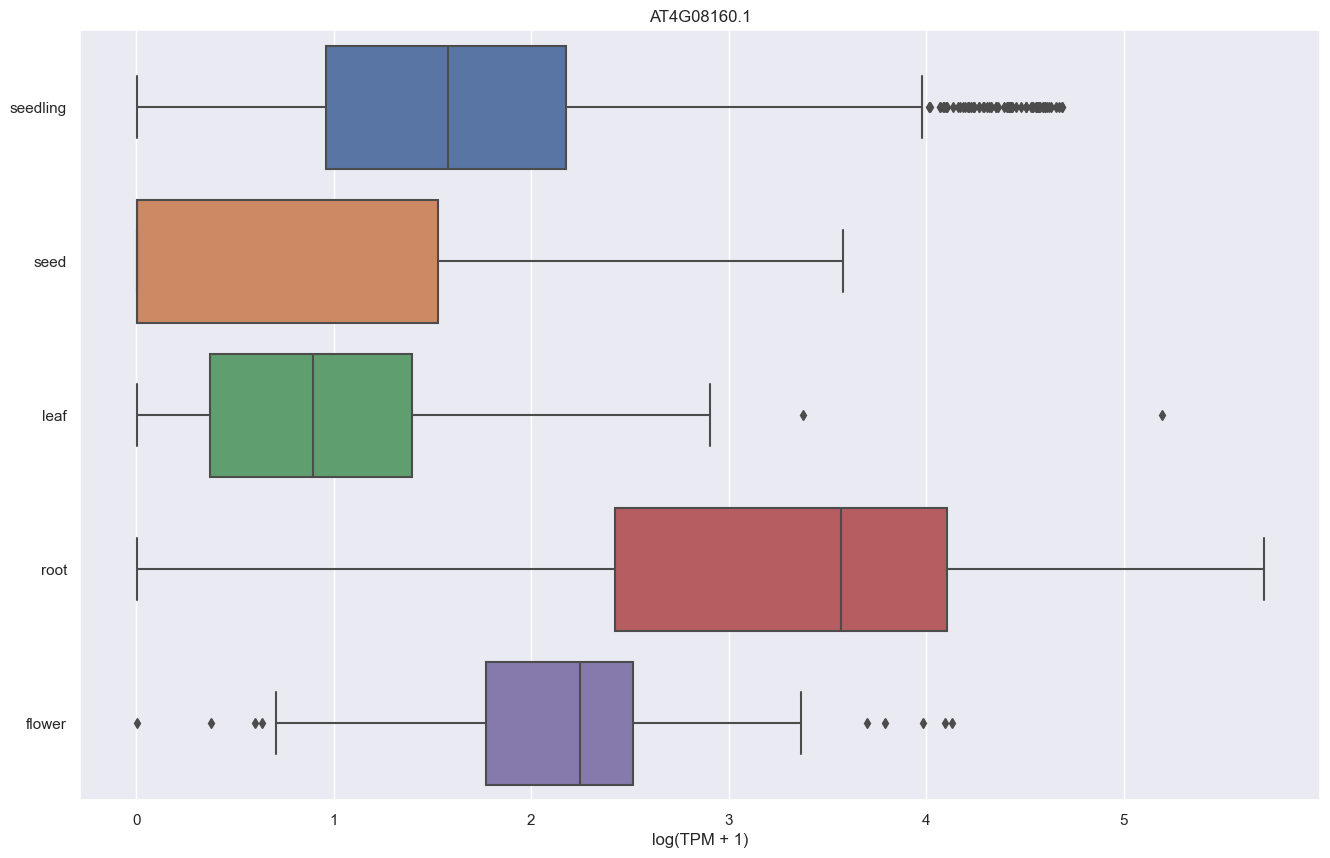

In [14]:
# Display an example of few transcript expressions per tissue

for transcript in transcripts :
	if transcript not in anndata.var.index : continue

	feature_anndata.gene_boxplot(
		data       = anndata,
		transcript = transcript,
		groupby    = 'Tissue',
		layer      = 'log1p',
		filename   = os.path.join(OUT_PLOT, 'tissue-log1p-' + transcript)
	)

	matplotlib.pyplot.show()

# 4. BoxCox

In [15]:
# Compute and save the boxcox1p tpm values

anndata, boxcox_factors = feature_anndata.compute_boxcox1p(
	data       = anndata,
	store_into = 'boxcox1p',
	layer      = mapping['boxcox1p'],
	eps        = 1.0,
	lmbda      = None
)

print('Lambda : {}'.format(boxcox_factors['lambda']))

Lambda : -0.14552661101589698


In [16]:
# Display anndata boxcox1p tpm matrix information

feature_anndata.show_matrix(anndata, layer = 'boxcox1p')

   Max value :   5.82196
  Mean value :   1.67215 ± 1.11229
Median value :   1.75020
   Min value :   0.00000

Total elements        :  83,900,583
Total elements =  0.0 :           0 [  0.00 %]
Total elements >  0.0 :  83,900,583 [100.00 %]
Total elements >  1.0 :  57,831,140 [ 68.93 %]
Total elements >  2.0 :  35,477,634 [ 42.29 %]
Total elements >  3.0 :  10,051,303 [ 11.98 %]
Total elements >  4.0 :     986,218 [  1.18 %]
Total elements >  5.0 :      16,094 [  0.02 %]

[[  2.393   1.054   0.596   1.877   3.435   1.853   0.761   3.722   2.999   2.123]
 [  2.451   0.001   0.870   1.954   3.460   1.544   0.867   3.707   2.827   2.035]
 [  2.720   0.395   0.498   2.133   3.514   1.773   0.001   3.719   2.844   2.055]
 [  2.603   0.842   0.486   2.018   3.527   1.135   0.629   3.687   3.063   2.044]
 [  2.701   1.039   0.869   1.549   3.587   1.740   0.001   3.550   1.194   1.836]]


## 4.1 Distribution

Function : numpy.mean
Genes below 10th percentile [   0.372556] :  2,058
Genes below 30th percentile [   1.062831] :  6,174
Genes above 70th percentile [   2.241758] :  6,174
Genes above 90th percentile [   2.904302] :  2,058



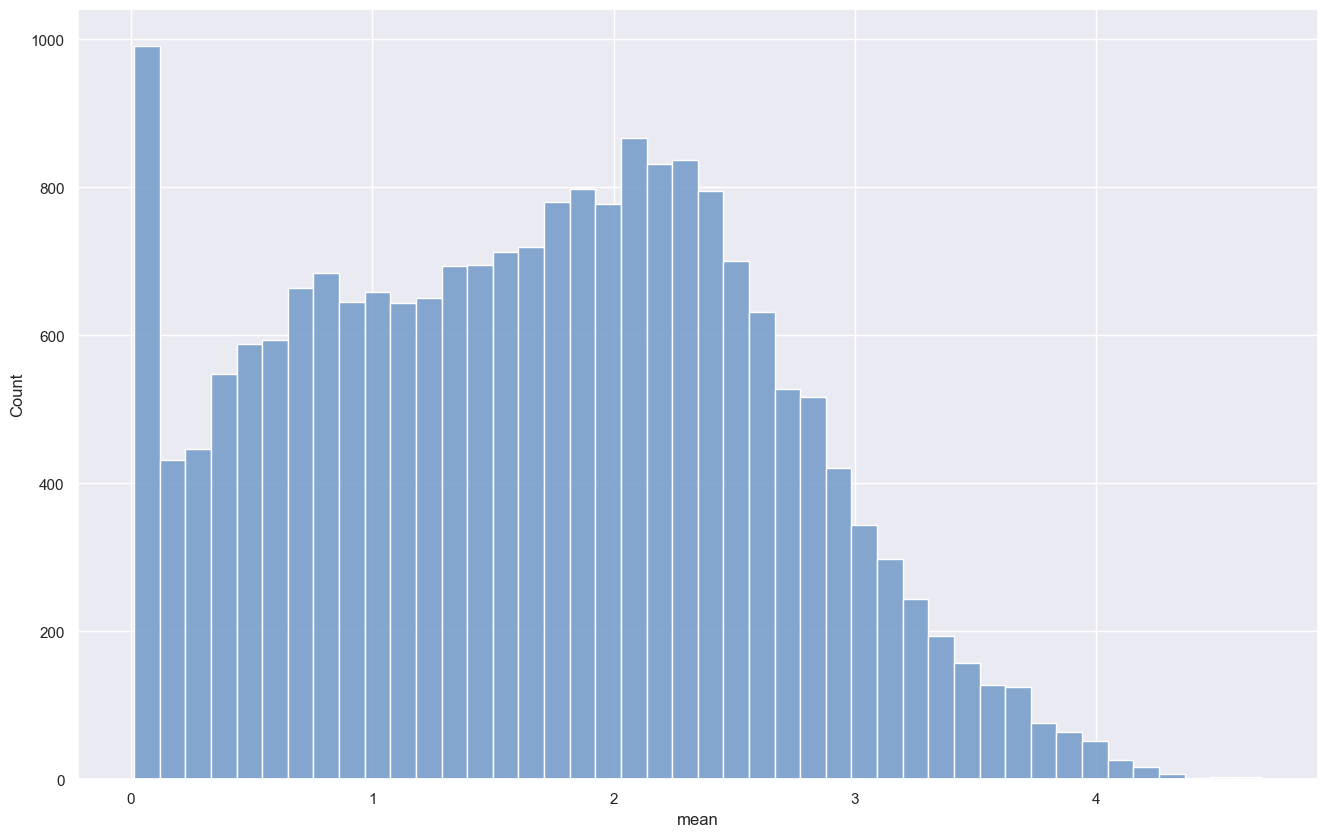

Function : __main__.percentile75
Genes below 10th percentile [   0.541018] :  2,058
Genes below 30th percentile [   1.506672] :  6,174
Genes above 70th percentile [   2.605993] :  6,174
Genes above 90th percentile [   3.242419] :  2,058



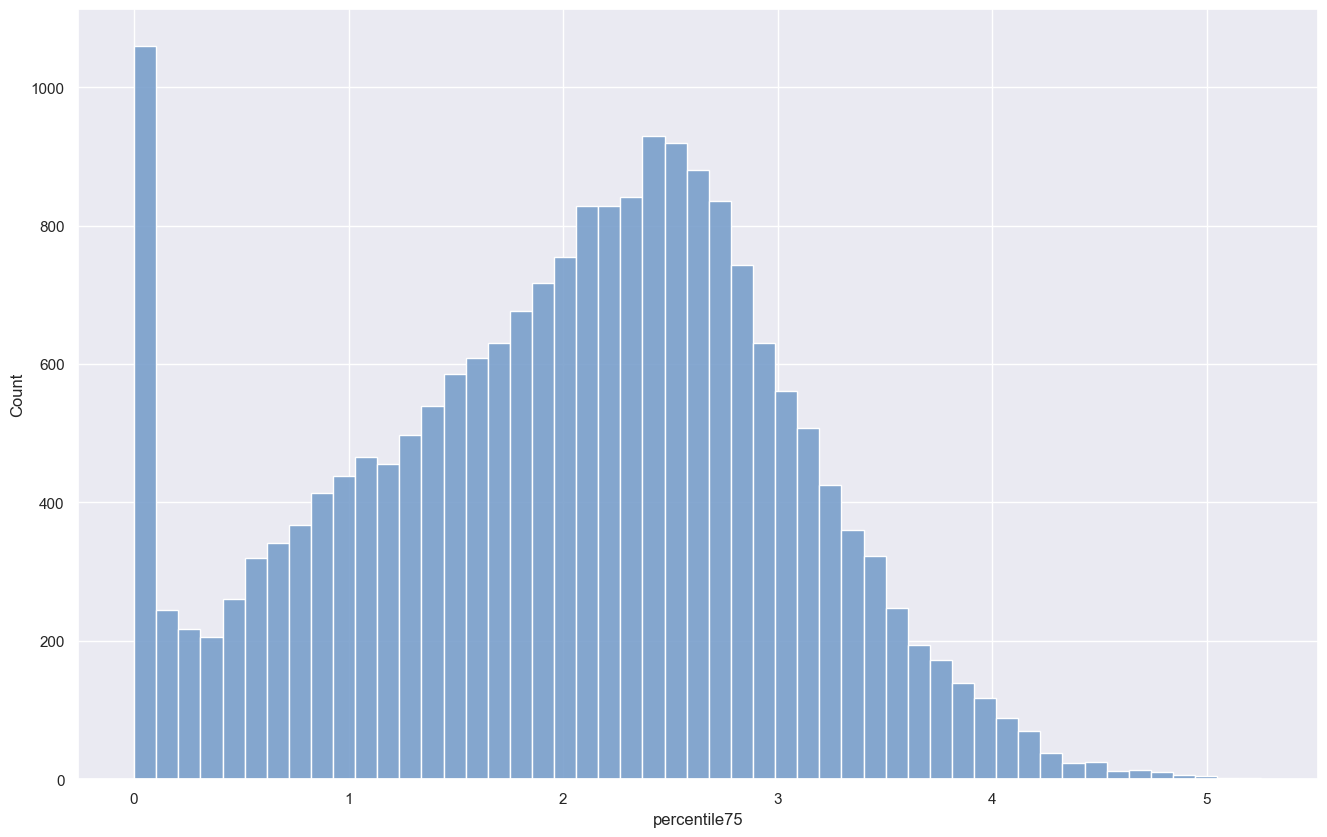

Function : numpy.amax
Genes below 10th percentile [   2.416163] :  2,058
Genes below 30th percentile [   2.982014] :  6,174
Genes above 70th percentile [   3.758178] :  6,174
Genes above 90th percentile [   4.337811] :  2,058



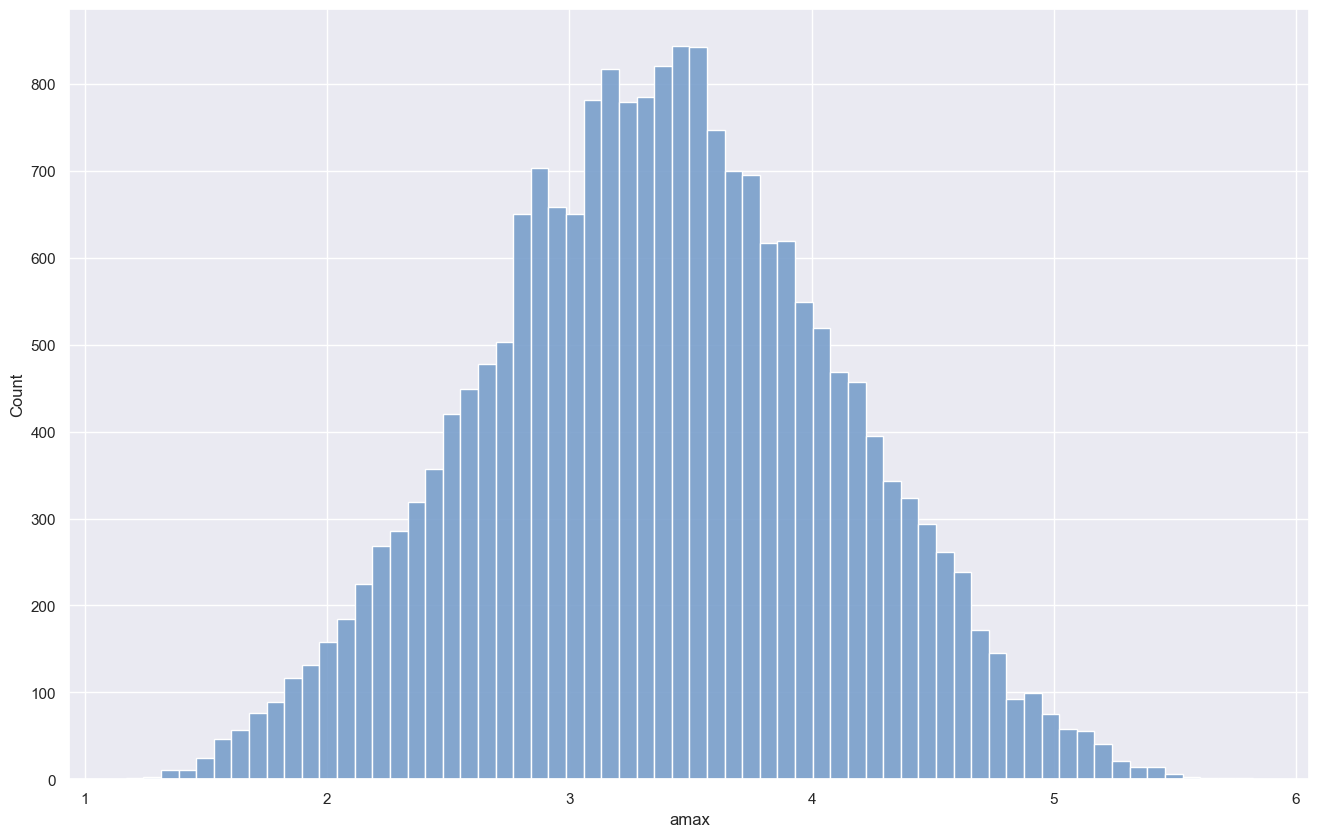

Function : numpy.std
Genes below 10th percentile [   0.317330] :  2,058
Genes below 30th percentile [   0.392908] :  6,174
Genes above 70th percentile [   0.598767] :  6,174
Genes above 90th percentile [   0.846200] :  2,058



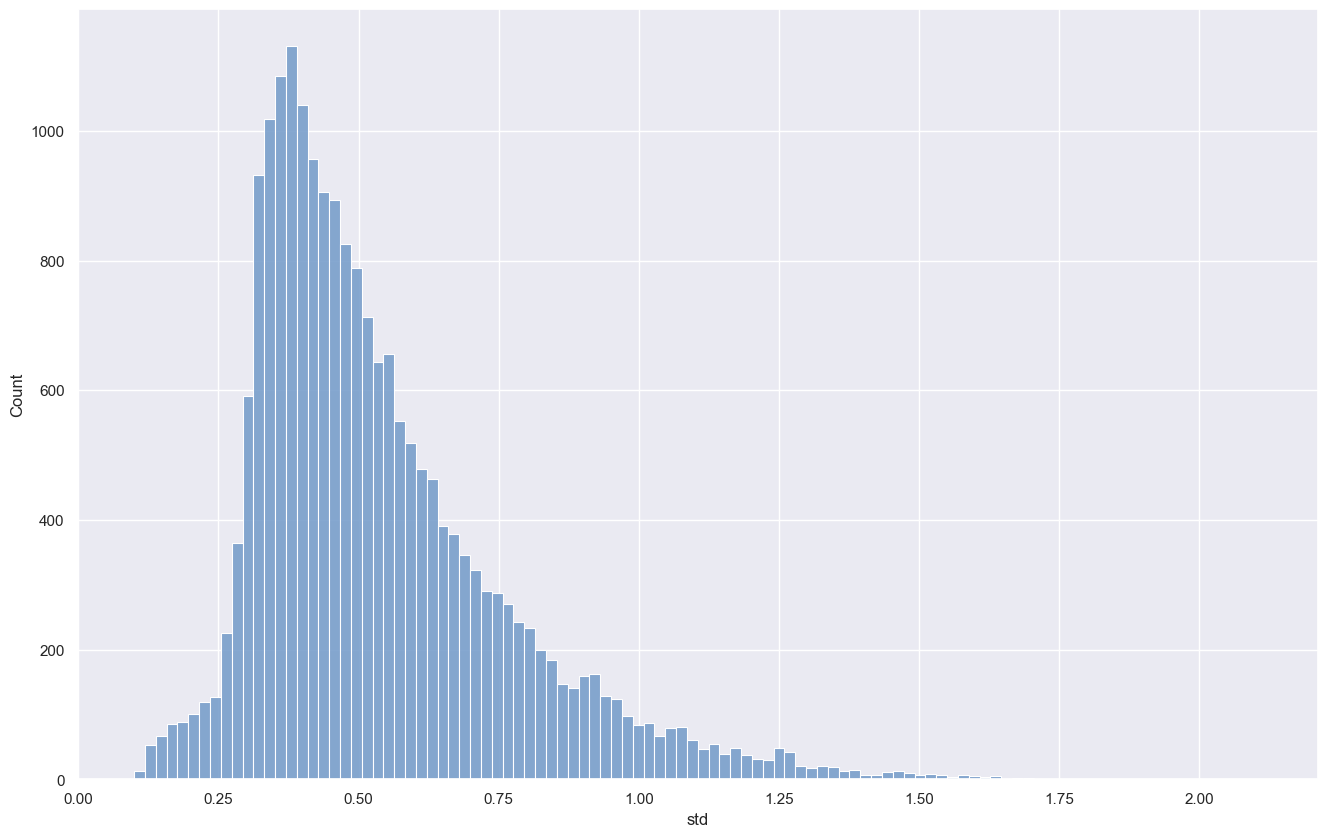

In [17]:
# Display boxcox1p tpm value distribution per gene

for name, function in functions :
	if name == 'min' : continue

	feature_anndata.tpm_histplot(
		data     = anndata,
		layer    = 'boxcox1p',
		function = function,
		filters  = None,
		filename = os.path.join(OUT_PLOT, 'distribution-boxcox1p-' + name)
	)

	matplotlib.pyplot.show()

## 4.2 Transcripts

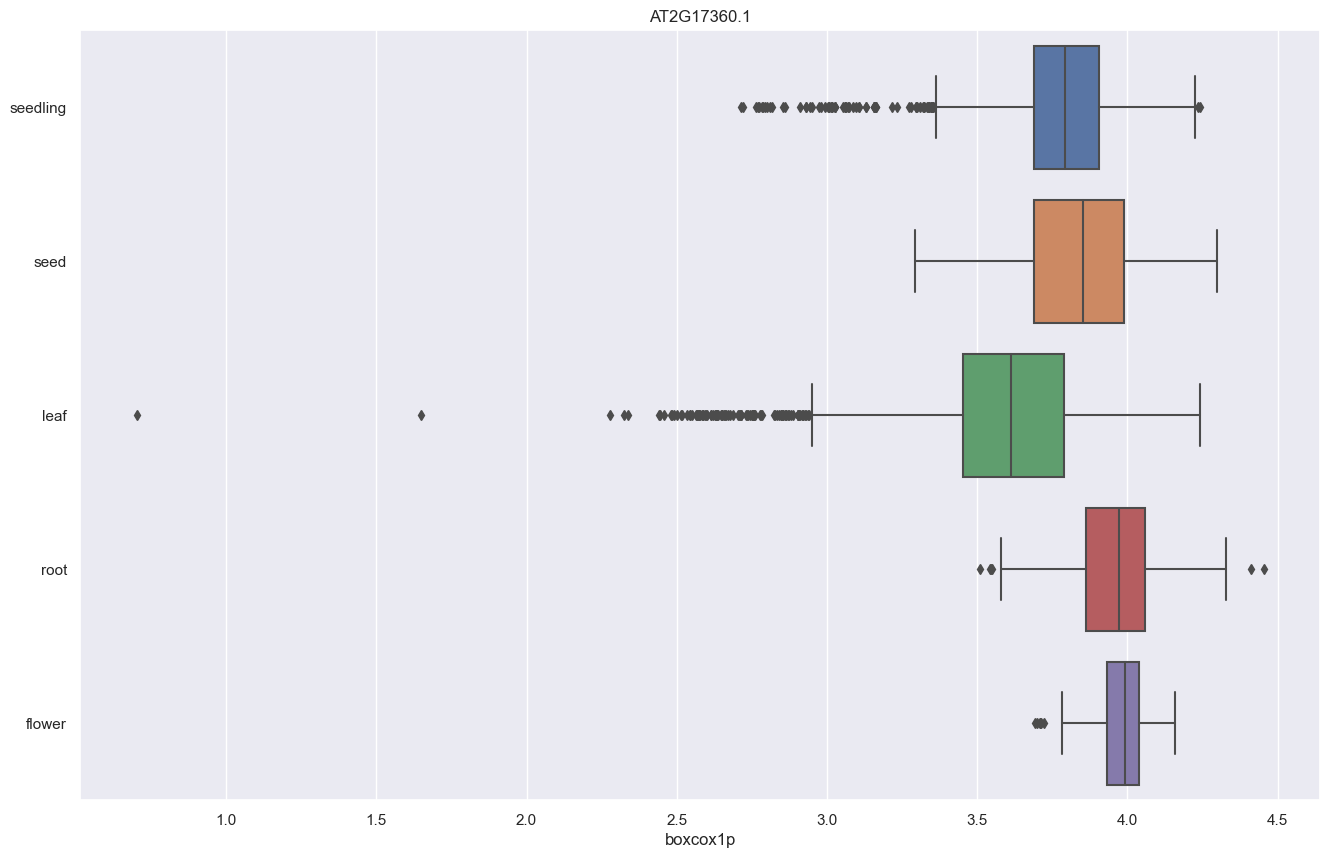

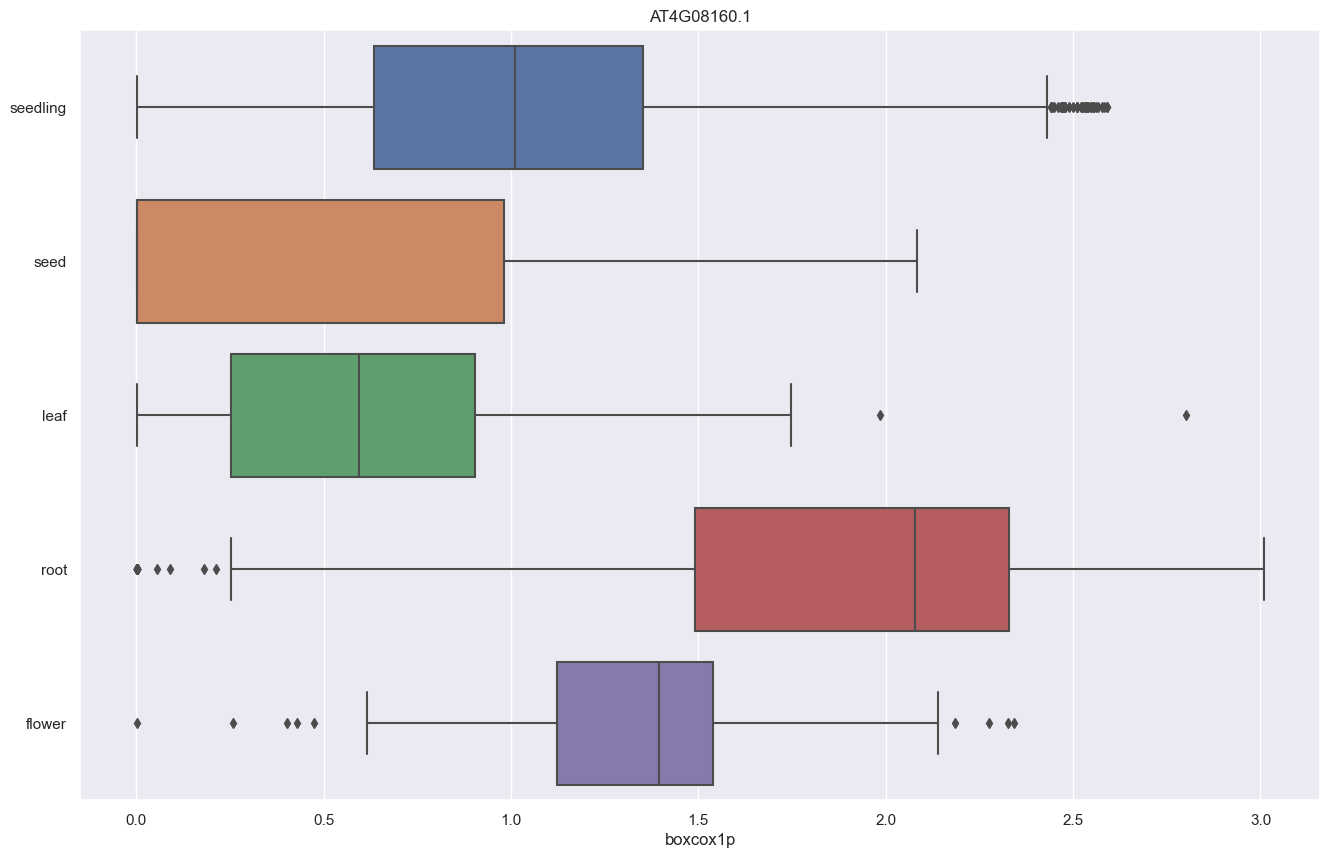

In [18]:
# Display an example of few transcript expressions per tissue

for transcript in transcripts :
	if transcript not in anndata.var.index : continue

	feature_anndata.gene_boxplot(
		data       = anndata,
		transcript = transcript,
		groupby    = 'Tissue',
		layer      = 'boxcox1p',
		filename   = os.path.join(OUT_PLOT, 'tissue-boxcox1p-' + transcript)
	)

	matplotlib.pyplot.show()

# 5. Normal

In [19]:
# Compute and save the normalized tpm values

anndata, normal_factors = feature_anndata.compute_normalized(
	data       = anndata,
	layer      = mapping['normal'],
	store_into = 'normal'
)

print('Min : {}'.format(normal_factors['min']))
print('Max : {}'.format(normal_factors['max']))

Min : 1.8680399241155468e-11
Max : 5.8219630427744


In [20]:
# Display normalized log1p tpm matrix information

feature_anndata.show_matrix(anndata, layer = 'normal')

   Max value :   1.00000
  Mean value :   0.28721 ± 0.19105
Median value :   0.30062
   Min value :   0.00000

Total elements        :  83,900,583
Total elements =  0.0 :           1 [  0.00 %]
Total elements >  0.0 :  83,900,582 [100.00 %]
Total elements >  0.1 :  64,986,603 [ 77.46 %]
Total elements >  0.3 :  42,039,649 [ 50.11 %]
Total elements >  0.5 :  11,714,638 [ 13.96 %]
Total elements >  0.7 :     771,723 [  0.92 %]

[[  0.411   0.181   0.102   0.322   0.590   0.318   0.131   0.639   0.515   0.365]
 [  0.421   0.000   0.150   0.336   0.594   0.265   0.149   0.637   0.486   0.349]
 [  0.467   0.068   0.086   0.366   0.604   0.304   0.000   0.639   0.489   0.353]
 [  0.447   0.145   0.083   0.347   0.606   0.195   0.108   0.633   0.526   0.351]
 [  0.464   0.178   0.149   0.266   0.616   0.299   0.000   0.610   0.205   0.315]]


## 5.1 Distribution

Function : numpy.mean
Genes below 10th percentile [   0.063992] :  2,058
Genes below 30th percentile [   0.182555] :  6,174
Genes above 70th percentile [   0.385052] :  6,174
Genes above 90th percentile [   0.498853] :  2,058



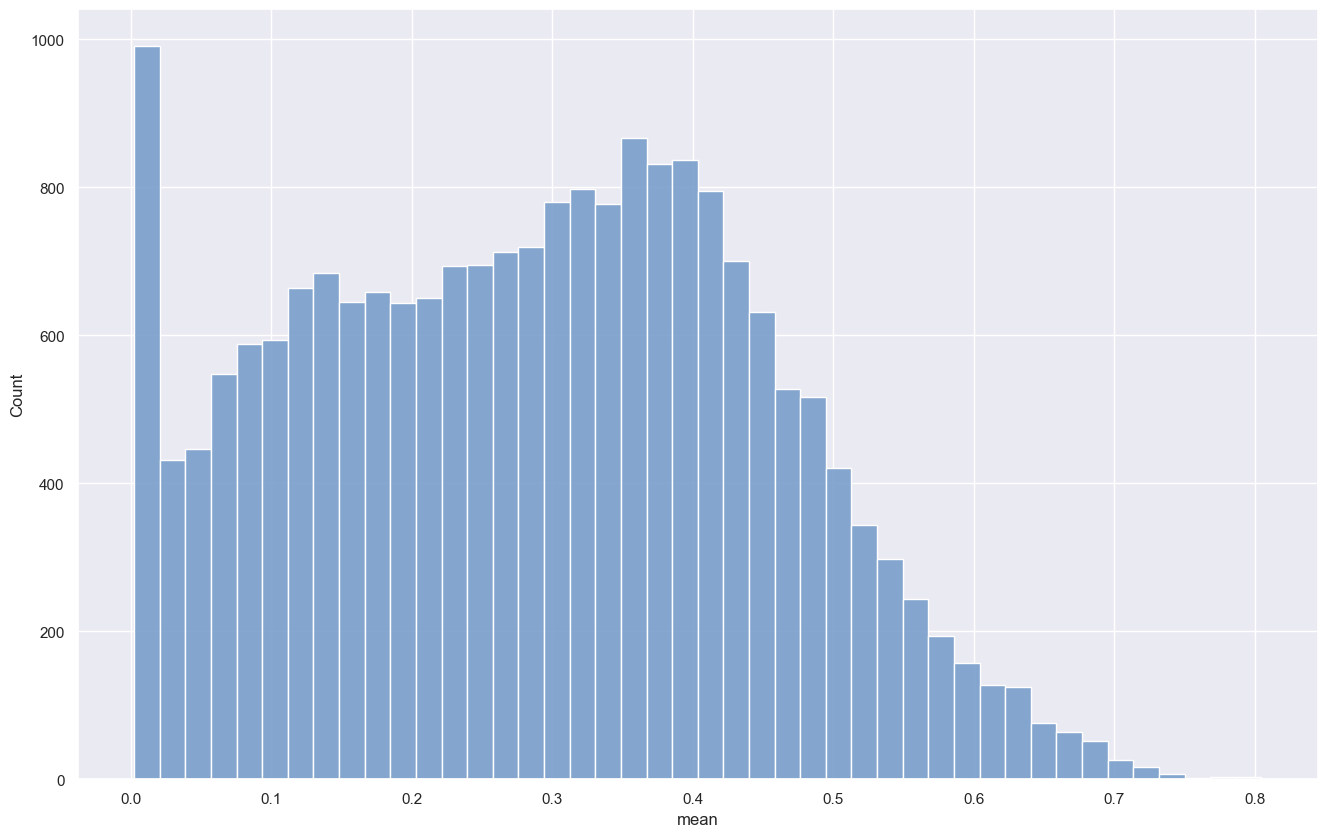

Function : __main__.percentile75
Genes below 10th percentile [   0.092927] :  2,058
Genes below 30th percentile [   0.258791] :  6,174
Genes above 70th percentile [   0.447614] :  6,174
Genes above 90th percentile [   0.556929] :  2,058



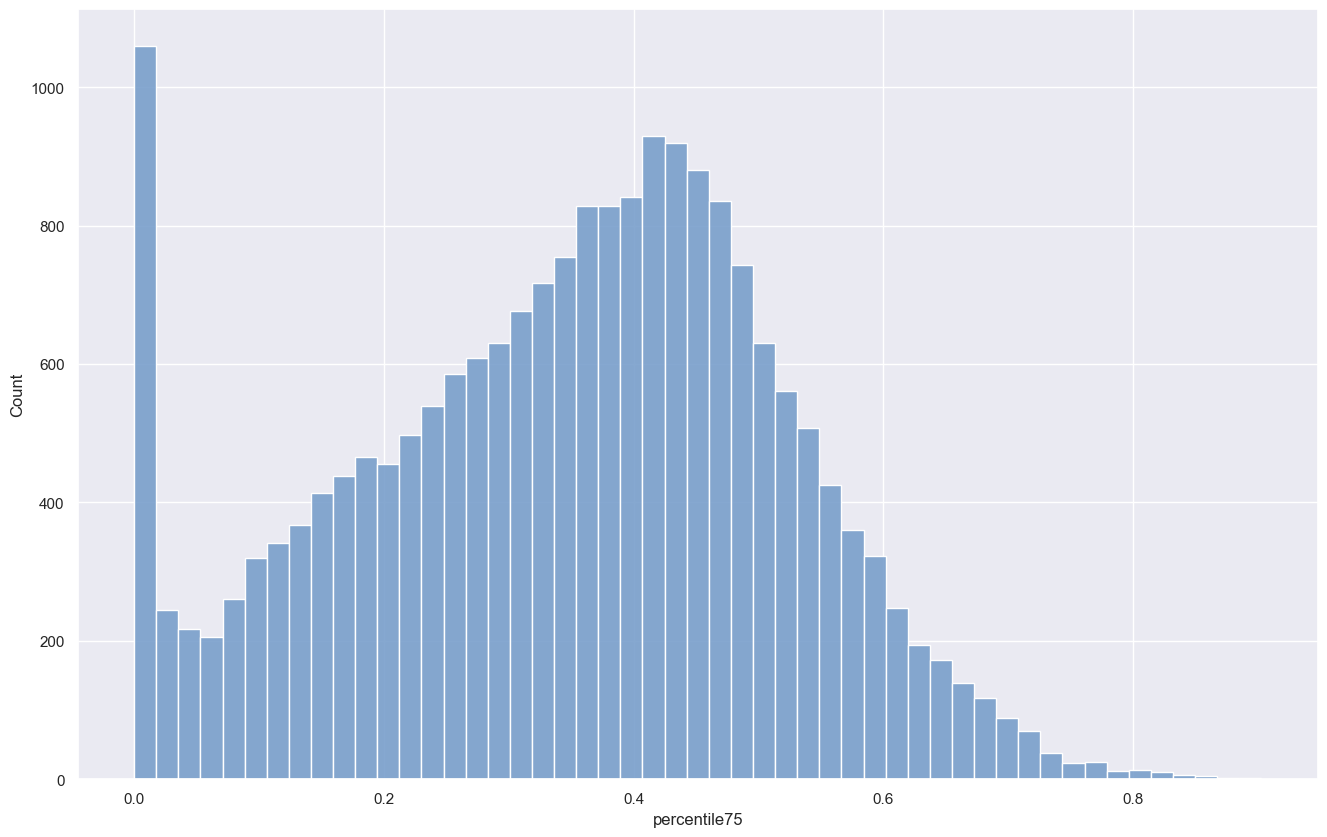

Function : numpy.amax
Genes below 10th percentile [   0.415008] :  2,058
Genes below 30th percentile [   0.512201] :  6,174
Genes above 70th percentile [   0.645517] :  6,174
Genes above 90th percentile [   0.745077] :  2,058



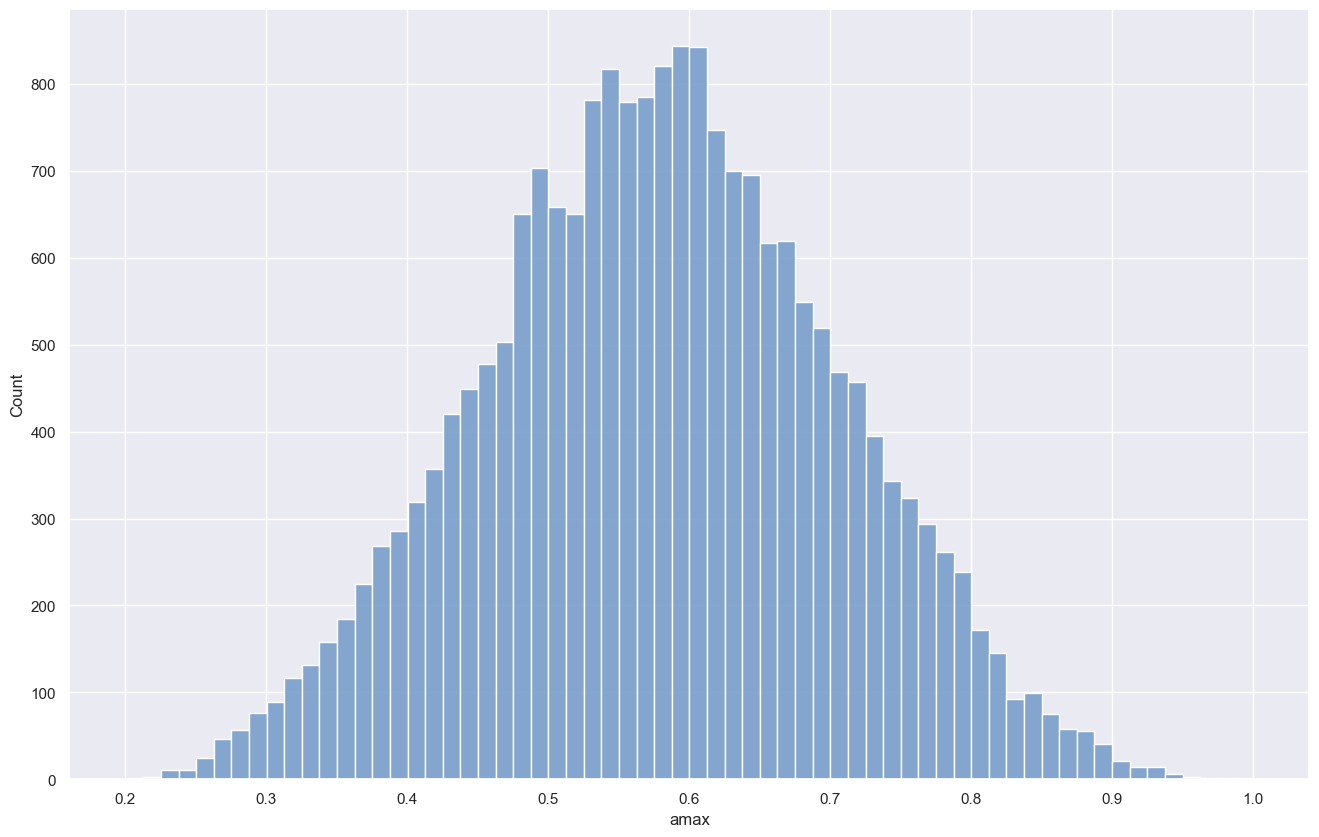

Function : numpy.std
Genes below 10th percentile [   0.054506] :  2,058
Genes below 30th percentile [   0.067487] :  6,174
Genes above 70th percentile [   0.102846] :  6,174
Genes above 90th percentile [   0.145346] :  2,058



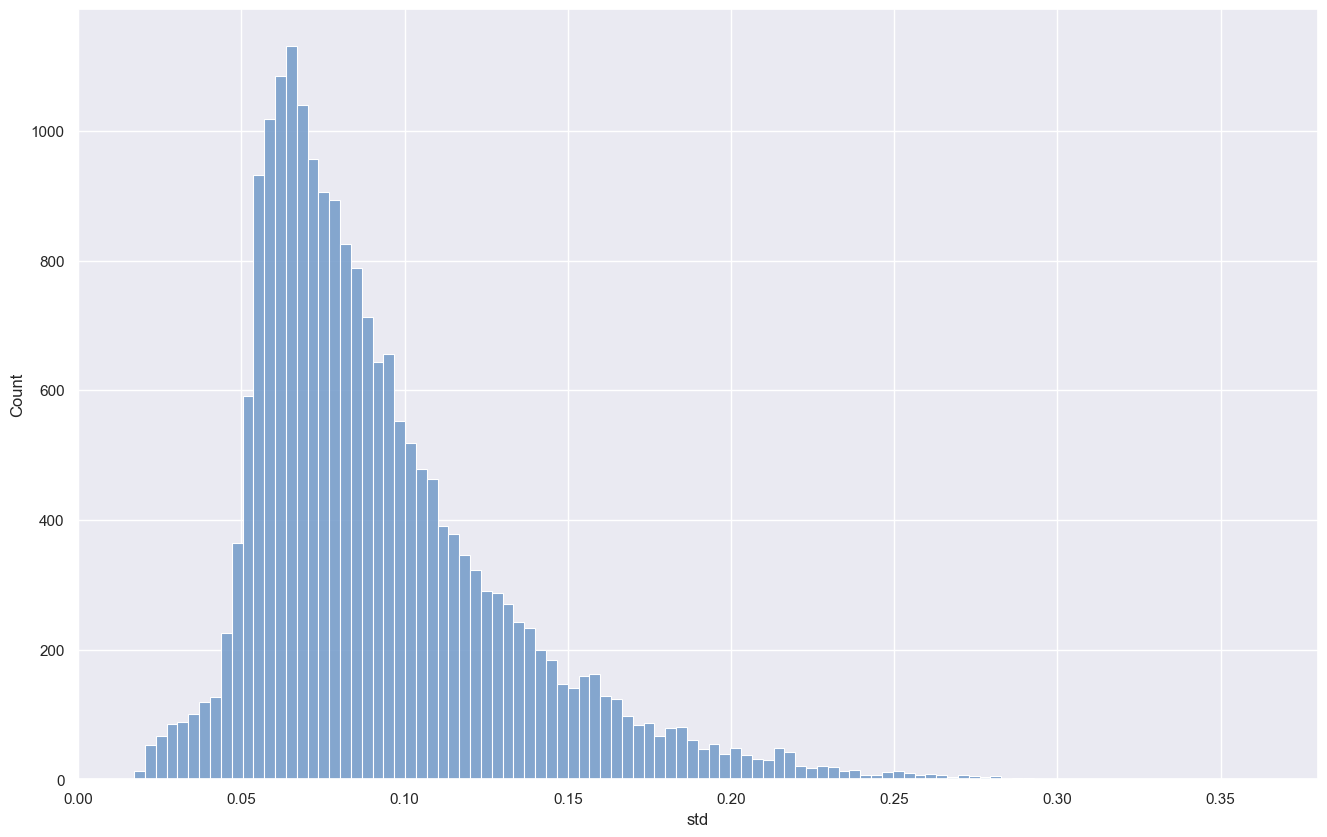

In [21]:
# Display normal tpm value distribution per gene

for name, function in functions :
	if name == 'min' : continue

	feature_anndata.tpm_histplot(
		data     = anndata,
		layer    = 'normal',
		function = function,
		filters  = None,
		filename = os.path.join(OUT_PLOT, 'distribution-nornal-' + name)
	)

	matplotlib.pyplot.show()

## 5.2 Transcripts

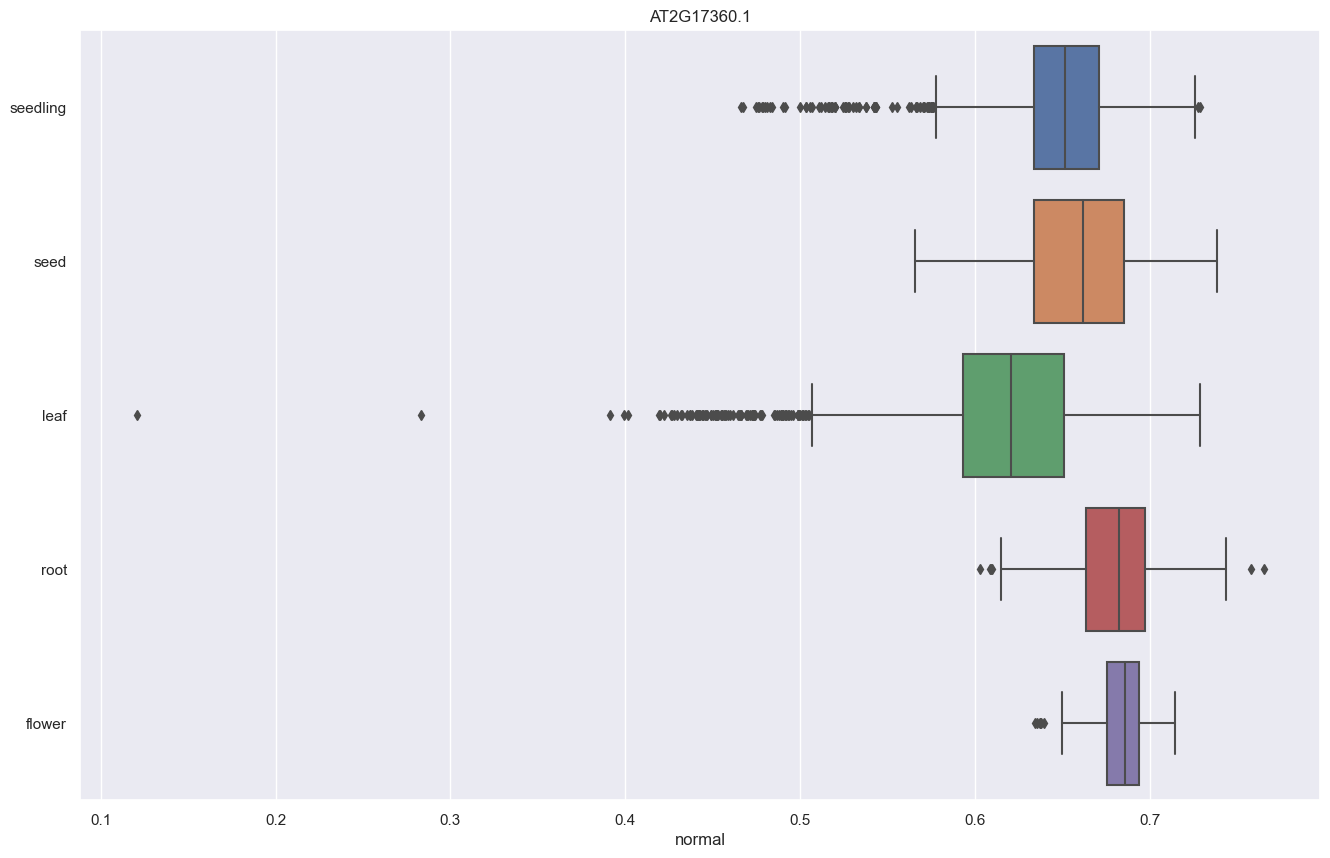

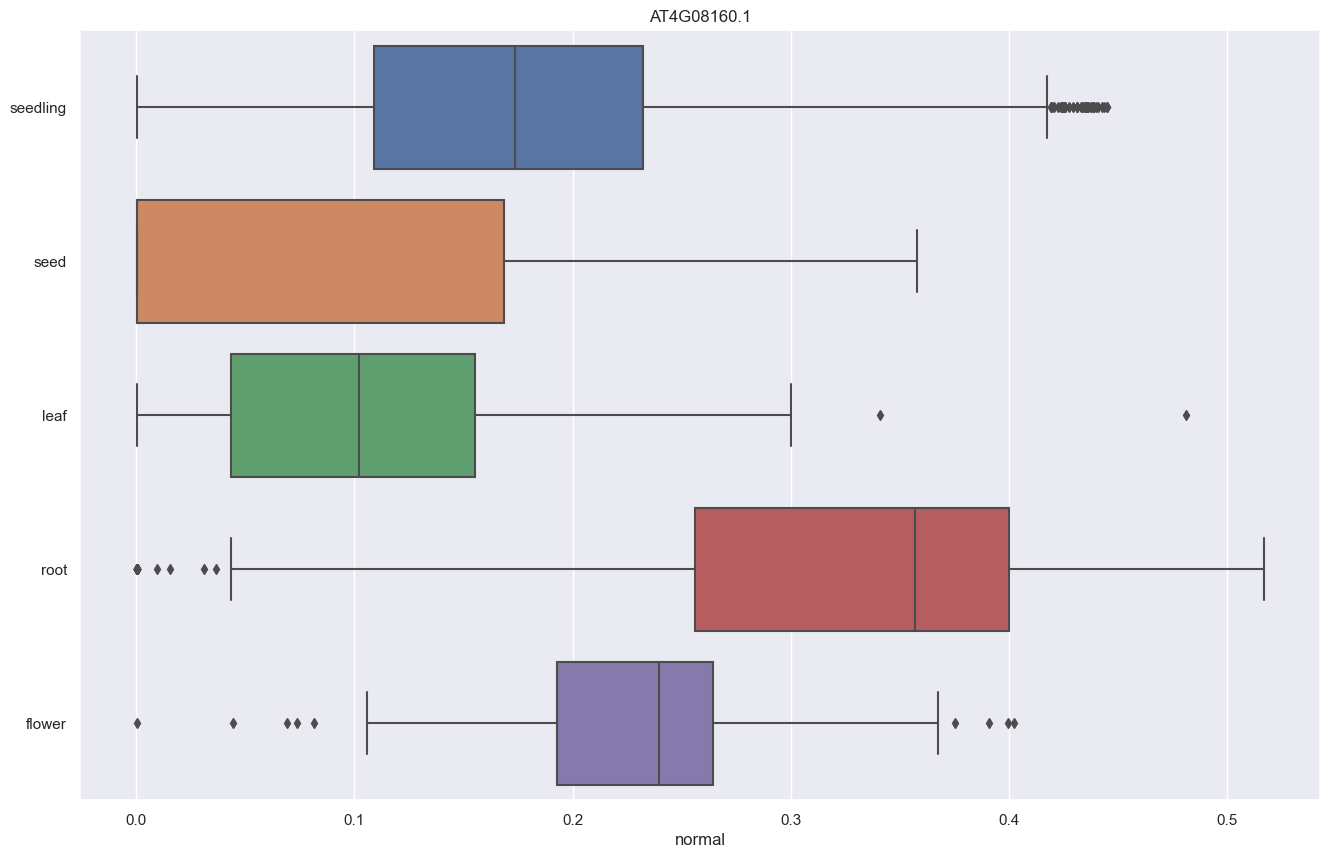

In [22]:
# Display an example of few transcript expressions per tissue

for transcript in transcripts :
	if transcript not in anndata.var.index : continue

	feature_anndata.gene_boxplot(
		data       = anndata,
		transcript = transcript,
		groupby    = 'Tissue',
		layer      = 'normal',
		filename   = os.path.join(OUT_PLOT, 'tissue-normal-' + transcript)
	)

	matplotlib.pyplot.show()

# 6. Standard

In [23]:
# Compute and save the standardized tpm values

anndata, standard_factors = feature_anndata.compute_standardized(
	data       = anndata,
	layer      = mapping['standard'],
	store_into = 'standard',
	axis       = None
)

print('Mean : {}'.format(standard_factors['mean']))
print(' Std : {}'.format(standard_factors['std']))

Mean : 1.6721478578363975
 Std : 1.1122920480017218


In [24]:
# Display anndata standardized tpm matrix information

feature_anndata.show_matrix(anndata, layer = 'standard')

   Max value :   3.73087
  Mean value :  -0.00000 ± 1.00000
Median value :   0.07017
   Min value :  -1.50334

Total elements        :  83,900,583
Total elements < -1.0 :  18,551,936 [ 22.11 %]
Total elements < -0.5 :  28,224,959 [ 33.64 %]
Total elements < -0.3 :  32,633,393 [ 38.90 %]
Total elements < -0.0 :  40,055,046 [ 47.74 %]
Total elements =  0.0 :           0 [  0.00 %]
Total elements >  0.0 :  43,845,537 [ 52.26 %]
Total elements >  0.3 :  35,319,799 [ 42.10 %]
Total elements >  0.5 :  29,119,392 [ 34.71 %]
Total elements >  1.0 :  14,380,861 [ 17.14 %]
Total elements >  2.0 :   1,346,059 [  1.60 %]

[[  0.648  -0.556  -0.968   0.184   1.585   0.162  -0.819   1.843   1.193   0.406]
 [  0.700  -1.502  -0.721   0.254   1.607  -0.115  -0.724   1.829   1.038   0.326]
 [  0.942  -1.148  -1.055   0.415   1.656   0.090  -1.502   1.840   1.054   0.345]
 [  0.837  -0.746  -1.067   0.311   1.668  -0.483  -0.938   1.811   1.250   0.334]
 [  0.925  -0.569  -0.722  -0.111   1.722   0.061 

## 6.1 Distribution

Function : numpy.mean
Genes below 10th percentile [  -1.168391] :  2,058
Genes below 30th percentile [  -0.547803] :  6,174
Genes above 70th percentile [   0.512105] :  6,174
Genes above 90th percentile [   1.107761] :  2,058



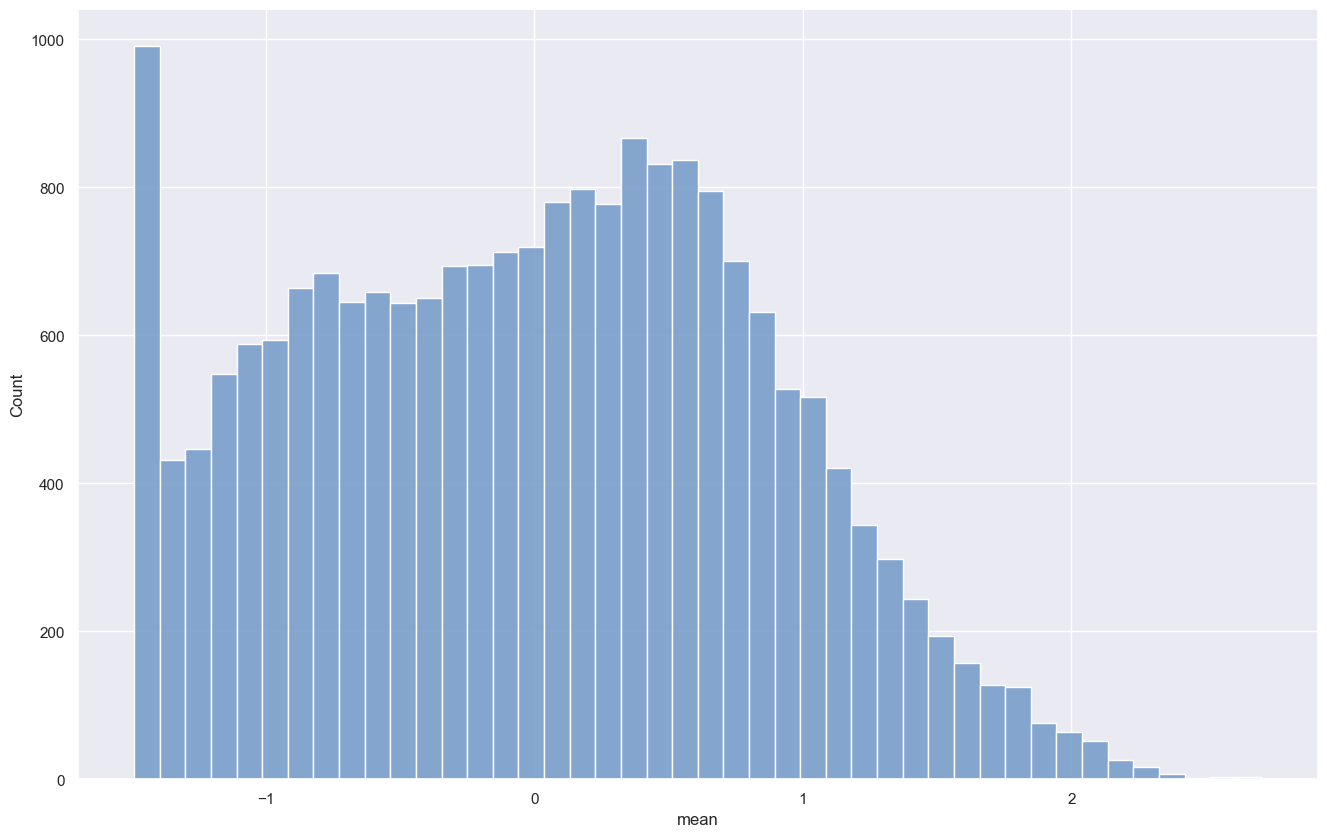

Function : __main__.percentile75
Genes below 10th percentile [  -1.016936] :  2,058
Genes below 30th percentile [  -0.148770] :  6,174
Genes above 70th percentile [   0.839569] :  6,174
Genes above 90th percentile [   1.411743] :  2,058



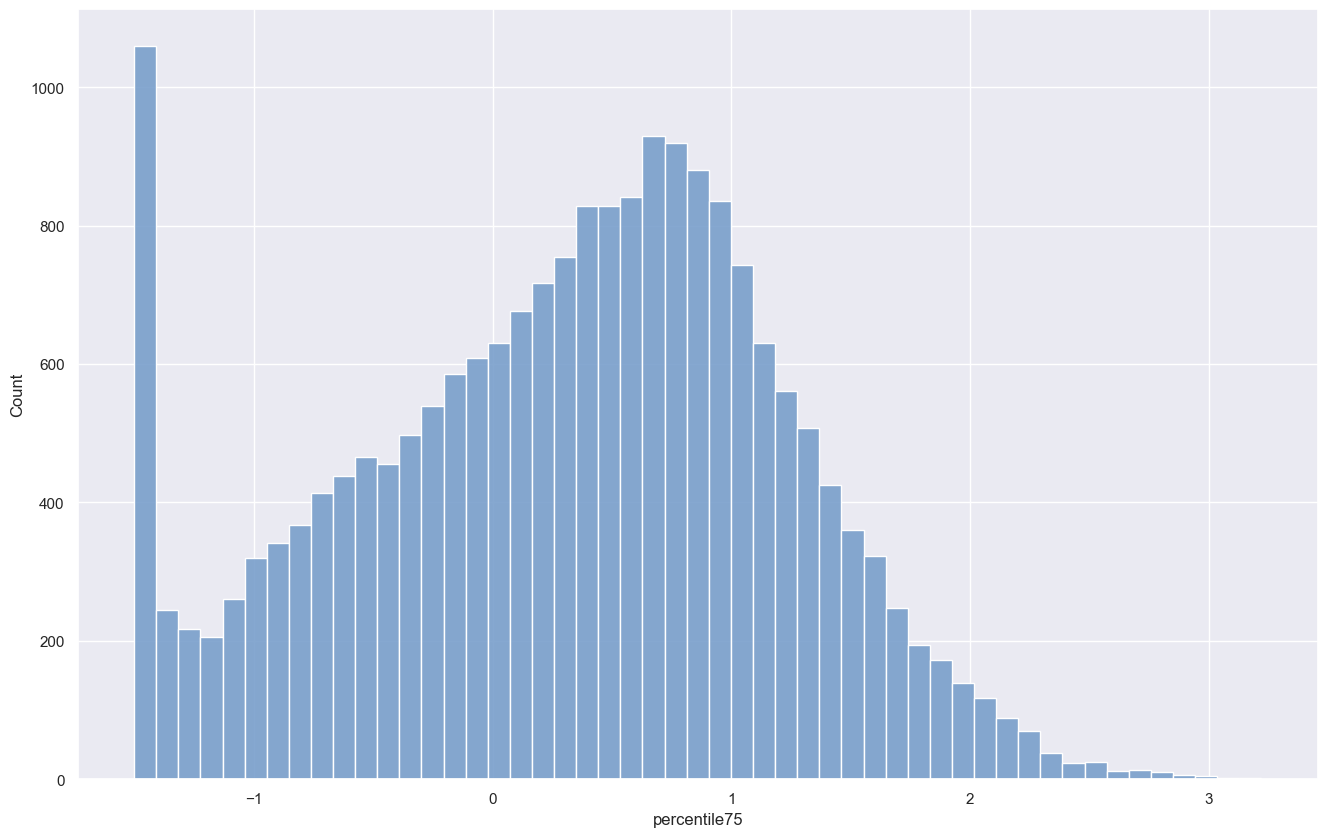

Function : numpy.amax
Genes below 10th percentile [   0.668903] :  2,058
Genes below 30th percentile [   1.177628] :  6,174
Genes above 70th percentile [   1.875434] :  6,174
Genes above 90th percentile [   2.396550] :  2,058



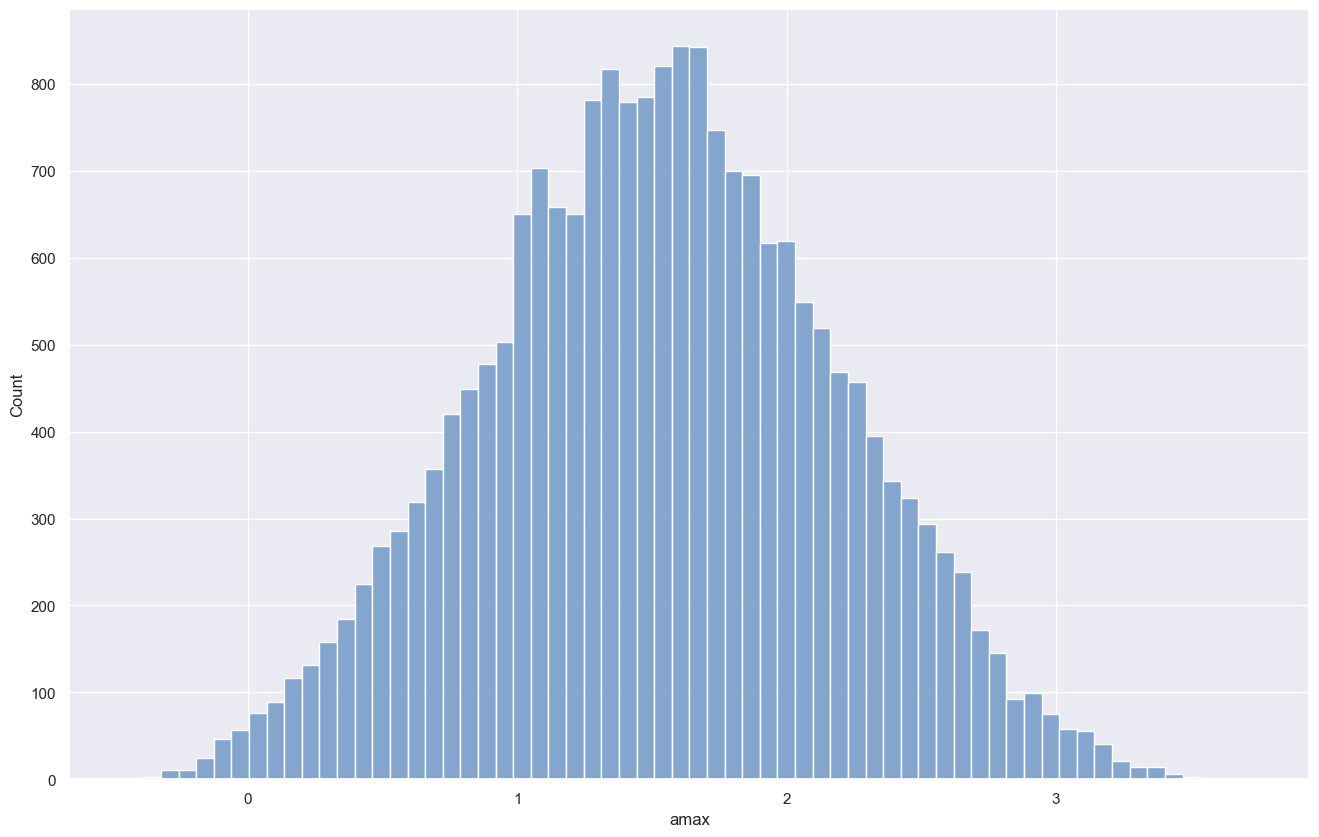

Function : numpy.std
Genes below 10th percentile [   0.285294] :  2,058
Genes below 30th percentile [   0.353242] :  6,174
Genes above 70th percentile [   0.538318] :  6,174
Genes above 90th percentile [   0.760771] :  2,058



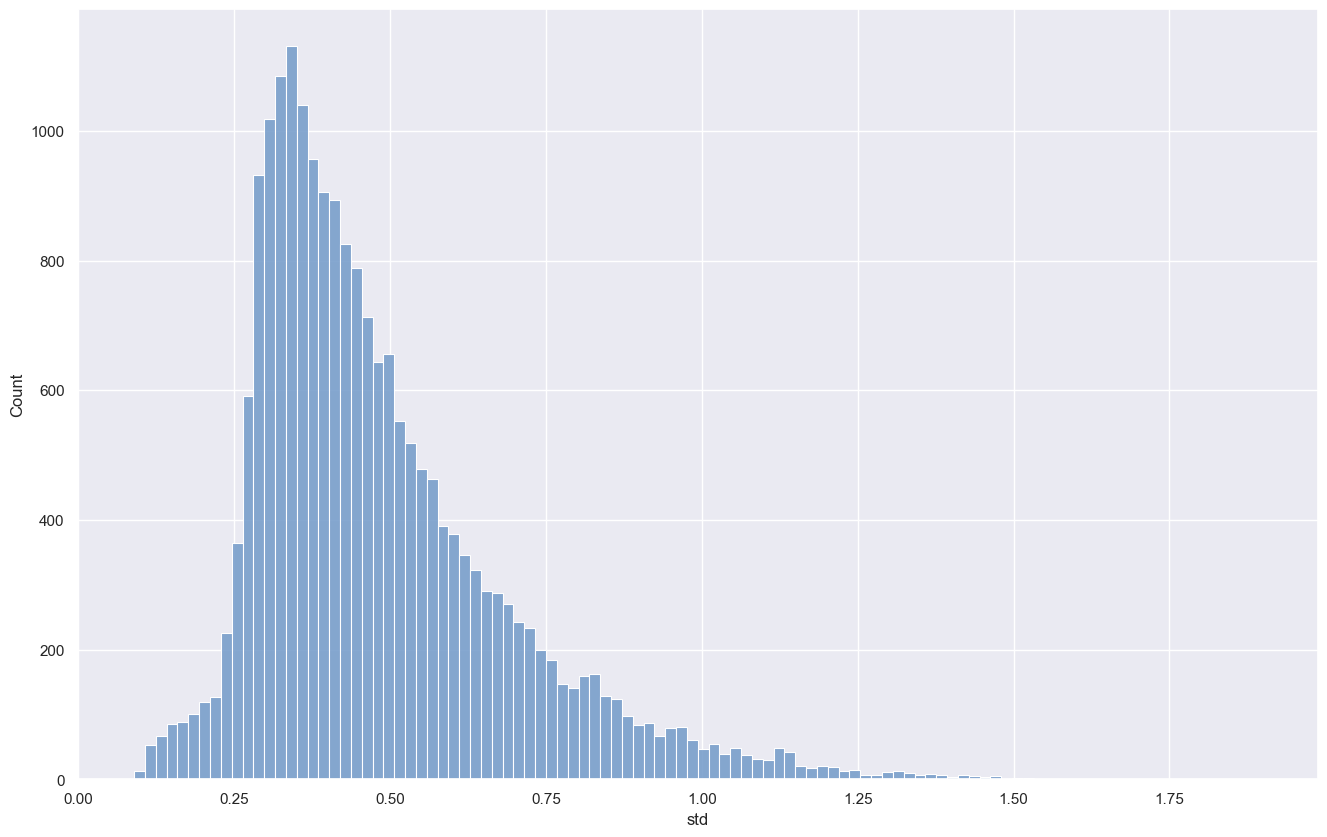

Function : numpy.amin
Genes below 10th percentile [  -1.503335] :  2,058
Genes below 30th percentile [  -1.502437] :  3,762
Genes above 70th percentile [  -1.502437] :  2,941
Genes above 90th percentile [  -1.440488] :  2,058



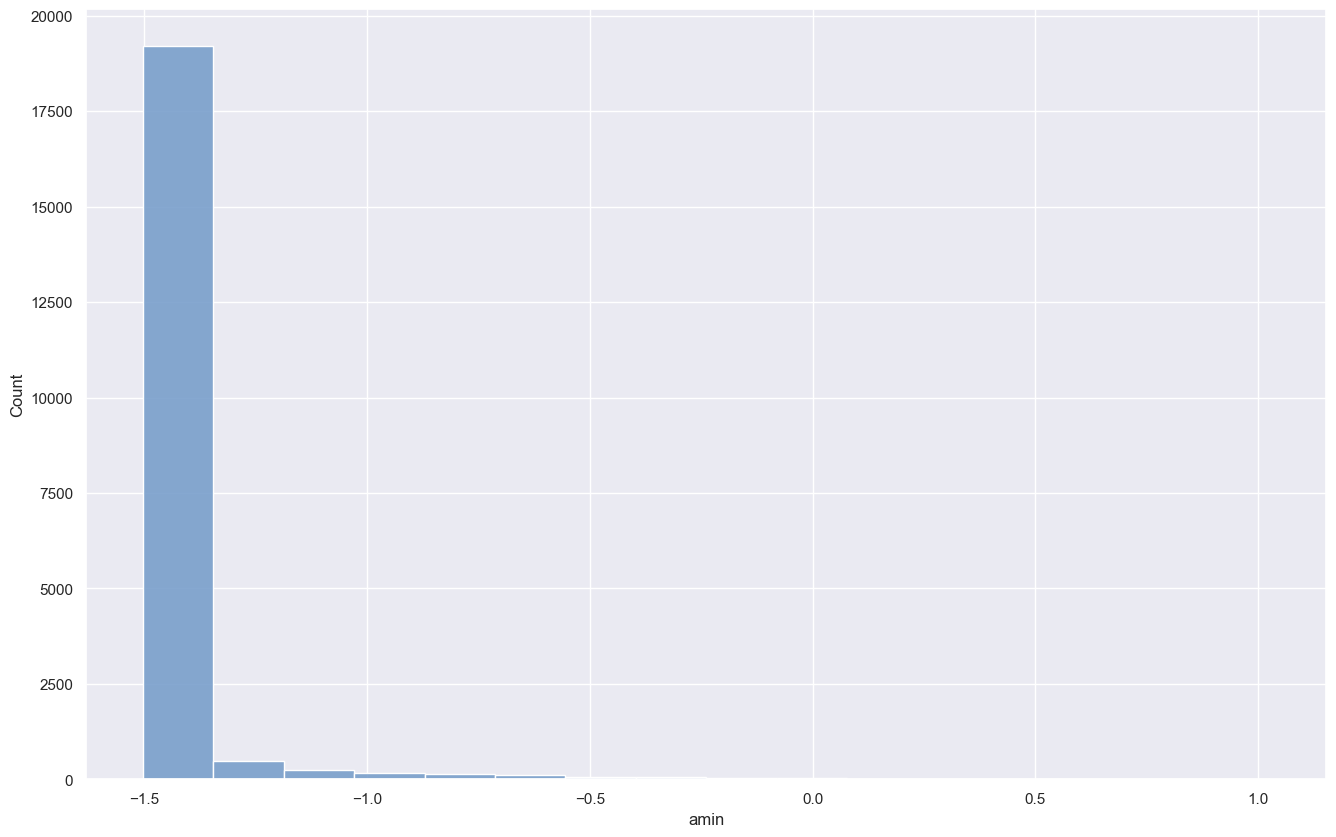

In [25]:
# Display standard tpm value distribution per gene

for name, function in functions :
	feature_anndata.tpm_histplot(
		data     = anndata,
		layer    = 'standard',
		function = function,
		filters  = None,
		filename = os.path.join(OUT_PLOT, 'distribution-standard-' + name)
	)

	matplotlib.pyplot.show()

## 6.2 Transcripts

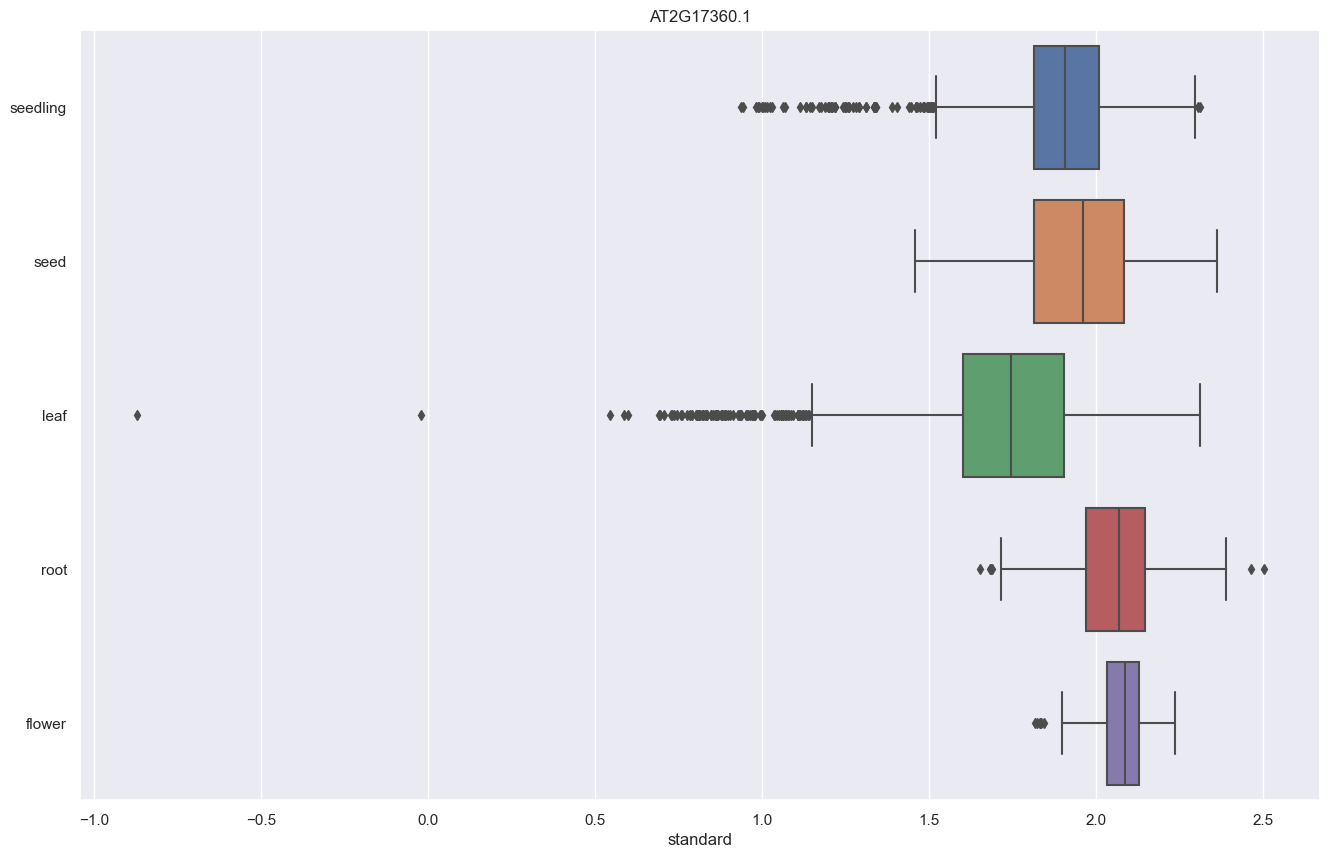

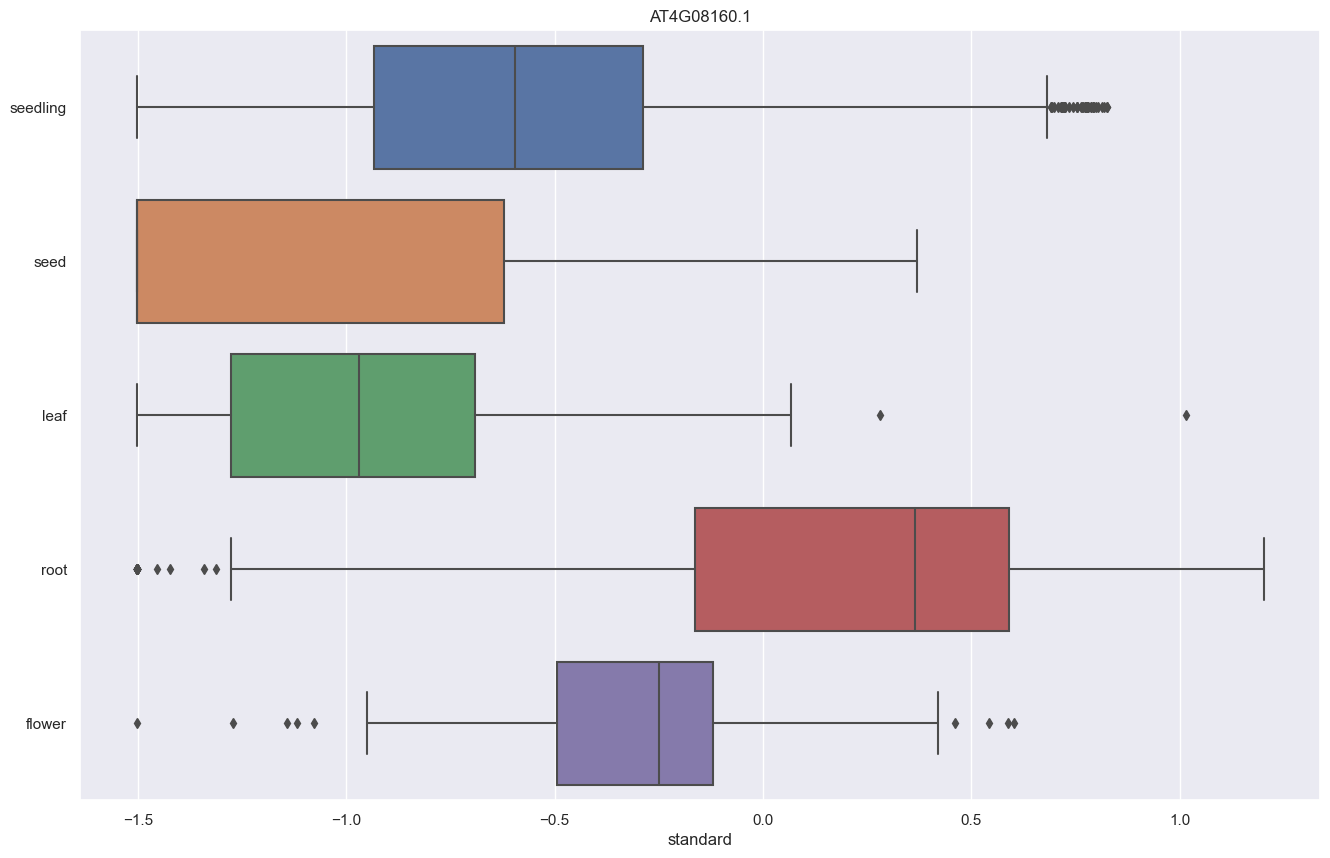

In [26]:
# Display an example of few transcript expressions per tissue

for transcript in transcripts :
	if transcript not in anndata.var.index : continue

	feature_anndata.gene_boxplot(
		data       = anndata,
		transcript = transcript,
		groupby    = 'Tissue',
		layer      = 'standard',
		filename   = os.path.join(OUT_PLOT, 'tissue-standard-' + transcript)
	)

	matplotlib.pyplot.show()

# 7. Save

In [27]:
# Save the annotated data with multiple layers

writer.write_h5ad(
	data     = anndata,
	filename = os.path.join(OUT_DATA, 'arabidopsis-r36.h5ad')
)

In [28]:
# Save processing info

writer.write_json(
	data     = mapping,
	filename = os.path.join(OUT_DATA, 'layer-mapping.json')
)

writer.write_json(
	data     = boxcox_factors,
	filename = os.path.join(OUT_DATA, 'factors-boxcox.json')
)

writer.write_json(
	data     = normal_factors,
	filename = os.path.join(OUT_DATA, 'factors-normal.json')
)

writer.write_json(
	data     = standard_factors,
	filename = os.path.join(OUT_DATA, 'factors-standard.json')
)